In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# !pip install tensorwatch
# !pip install graphviz
# !pip install pretrainedmodels

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import os
import numpy as np
import math
import time
import random
import pandas as pd

import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import _LRScheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import Parameter

from torchvision import transforms
import torchvision.models as models

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications import ResNet50, DenseNet121, EfficientNetB0
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
#import pretrainedmodels

import warnings
warnings.filterwarnings(action='ignore')
print(torch.__version__)

2.4.0


In [ ]:
ruta = '/kaggle/input/tesis-yuca-uoc'

In [ ]:
os.listdir(ruta)

['extraimages', 'sample_submission_file.csv', 'random.txt', 'test', 'train']

In [ ]:
print('Imágenes de Entrenamiento: %d' %len(os.listdir(
    os.path.join(ruta, "train/train"))))

Imágenes de Entrenamiento: 5


In [ ]:
ruta_train = '/kaggle/input/tesis-yuca-uoc/train/train'   # cmd, healthy, cgm, cbsd, cbb 2658+316+773+1443+466 == 6122
ruta_test = '/kaggle/input/tesis-yuca-uoc/test/test/0'
print(len(os.listdir(ruta_train)))
print(len(os.listdir(ruta_test)))

5
3774


In [ ]:
print('Conjunto de Entrenamiento :')
enfermedad  = []
cantidad = []
for cls in os.listdir('/kaggle/input/tesis-yuca-uoc/train/train'):
    print('{}:{}'.format(cls, len(os.listdir(os.path.join('/kaggle/input/tesis-yuca-uoc/train/train',cls)))))
    enfermedad.append(cls)
    cantidad.append(len(os.listdir(os.path.join('/kaggle/input/tesis-yuca-uoc/train/train',cls))))


Conjunto de Entrenamiento :
cmd:2658
cbb:466
cbsd:1443
healthy:316
cgm:773


In [ ]:
classes = ['cmd', 'cbb', 'cbsd', 'healthy', 'cgm']

# INICIO Nuevo modelo

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os

In [ ]:
# --- Configuración inicial ---
# Supongamos que las imágenes están organizadas en carpetas por clase
DATASET_DIR = ruta_train  # Cambiar a la ruta real
IMG_SIZE = (224, 224)  # Tamaño de entrada para EfficientNet
BATCH_SIZE = 32

In [ ]:
# --- Preprocesamiento y Data Augmentation ---
data_gen = ImageDataGenerator(
    rescale=1.0/255,  # Normalización de imágenes
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Separar datos de validación
)

train_data = data_gen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_data = data_gen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 4527 images belonging to 5 classes.
Found 1129 images belonging to 5 classes.


In [ ]:
class_labels = list(train_data.class_indices.keys())

In [ ]:
# # Calcular los pesos de las clases para abordar el desbalanceo
#class_labels = list(train_data.class_indices.keys())
# class_counts = train_data.classes
# class_weights = compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(class_counts),
#     y=class_counts
# )
# class_weights = {i: weight for i, weight in enumerate(class_weights)}

# print("Pesos", class_weights)

In [ ]:
# --- Modelo 1: CNN básica ---
def create_basic_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [ ]:
# --- Modelo 2: CNN con Dropout ---
def create_cnn_with_dropout(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.Dropout(0.5),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model


In [ ]:
IMG_SIZE  = 224


# Transfer Learning con EfficientNetB0
base_modelb7 = EfficientNetB0(weights='imagenet',
                              include_top=False,
                              input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_modelb7.trainable = True  # Congelar las capas base

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
efficientnet_model = Sequential([
    base_modelb7,
    GlobalAveragePooling2D(),
    Dense(5, activation='softmax')  # 5 clases: 0, 1, 2, 3, 4
])

In [ ]:
# Compilar el modelo
efficientnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

In [ ]:
# Entrenamiento del modelo
history_efficientnet = efficientnet_model.fit(
    train_data,
    epochs=10,
    validation_data=val_data,
    class_weight={
        'cmd': 1.0,
        'cbb': 4.0,  # Aumentar peso
        'cbsd': 2.0,
        'healthy': 5.0,  # Máximo peso
        'cgm': 3.0
    },
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/10


I0000 00:00:1734700436.257063     114 service.cc:145] XLA service 0x784ad8016a60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734700436.257145     114 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/142 ━━━━━━━━━━━━━━━━━━━━ 3:07:55 80s/step - accuracy: 0.1250 - loss: 1.7815

I0000 00:00:1734700480.804159     114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


142/142 ━━━━━━━━━━━━━━━━━━━━ 217s 974ms/step - accuracy: 0.6549 - loss: 0.9336 - val_accuracy: 0.0824 - val_loss: 1.7891 - learning_rate: 0.0010
Epoch 2/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 75s 504ms/step - accuracy: 0.8137 - loss: 0.5466 - val_accuracy: 0.2516 - val_loss: 1.7833 - learning_rate: 0.0010
Epoch 3/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 74s 500ms/step - accuracy: 0.8332 - loss: 0.4742 - val_accuracy: 0.0558 - val_loss: 3.0093 - learning_rate: 0.0010
Epoch 4/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 74s 499ms/step - accuracy: 0.8702 - loss: 0.3911 - val_accuracy: 0.0602 - val_loss: 2.9433 - learning_rate: 0.0010
Epoch 5/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 73s 496ms/step - accuracy: 0.9029 - loss: 0.2830 - val_accuracy: 0.6298 - val_loss: 0.9963 - learning_rate: 2.0000e-04
Epoch 6/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 74s 498ms/step - accuracy: 0.9210 - loss: 0.2212 - val_accuracy: 0.8025 - val_loss: 0.6291 - learning_rate: 2.0000e-04
Epoch 7/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 73s 493ms/step - accuracy: 0.940

<Figure size 640x480 with 0 Axes>

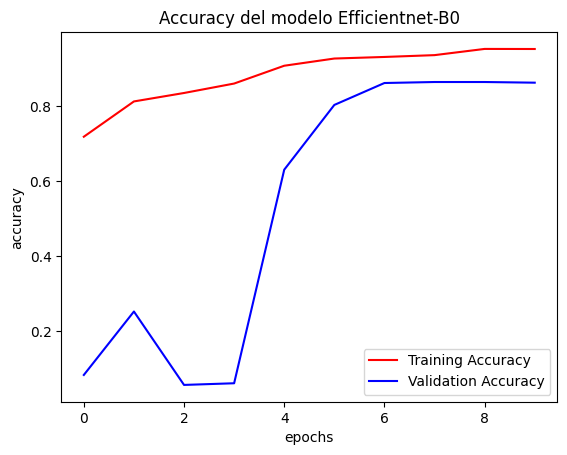

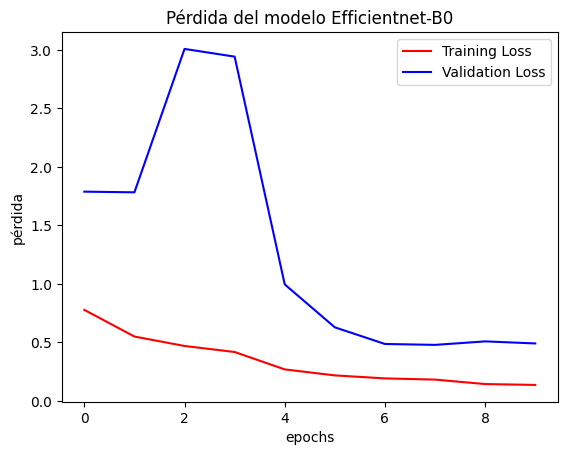

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history_efficientnet.history['accuracy']
val_acc = history_efficientnet.history['val_accuracy']
loss = history_efficientnet.history['loss']
val_loss = history_efficientnet.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Accuracy del modelo Efficientnet-B0')
plt.legend()
plt.figure()


plt.plot(epochs, loss, 'r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.xlabel('epochs')
plt.ylabel('pérdida')
plt.title('Pérdida del modelo Efficientnet-B0')
plt.legend()
plt.figure()



In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predicciones y evaluación
y_pred = efficientnet_model.predict(val_data)
y_pred_classes = y_pred.argmax(axis=1)
y_true = val_data.classes

# Reporte por clase
print(classification_report(y_true, y_pred_classes, target_names=classes))

36/36 ━━━━━━━━━━━━━━━━━━━━ 23s 507ms/step
              precision    recall  f1-score   support

         cmd       0.07      0.08      0.07        93
         cbb       0.26      0.23      0.24       288
        cbsd       0.15      0.14      0.14       154
     healthy       0.46      0.48      0.47       531
         cgm       0.04      0.05      0.05        63

    accuracy                           0.31      1129
   macro avg       0.20      0.20      0.20      1129
weighted avg       0.31      0.31      0.31      1129



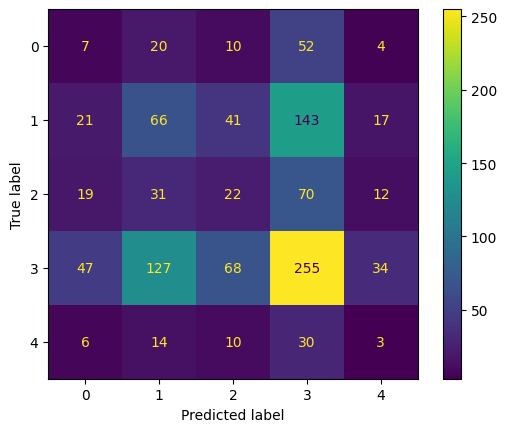

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predicciones y evaluación
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


In [ ]:
from PIL import Image
import cv2 as cv

def categorizar(ruta):
  img = Image.open(ruta)
  img = img.convert("RGB")
  img = np.array(img).astype(float)/255
  img = cv.resize(img, (224, 224))
  prediccion = efficientnet_model.predict(img.reshape(-1, 224, 224, 3))
  return np.argmax(prediccion, axis=-1)

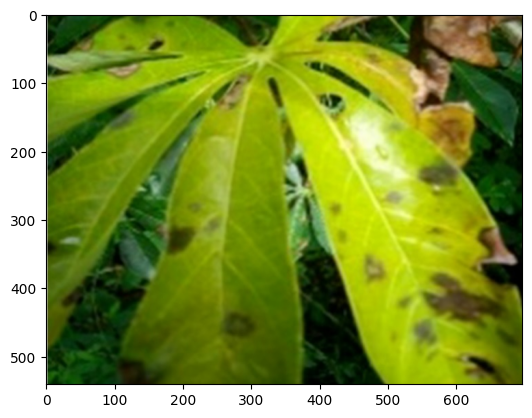

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
('/kaggle/input/pruebas-yuca', 'cbb.jpg')
cmd
[0]


In [ ]:
import cv2 as cv
ruta = "/kaggle/input/pruebas-yuca/cbb.jpg"

image = cv2.imread(ruta)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()
prediccion = categorizar(ruta)
prediccion1 = int(prediccion)
print(os.path.split(ruta))
print(classes[prediccion1])
print(prediccion)

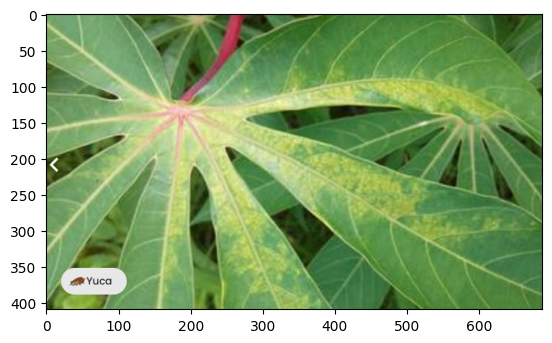

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
('/kaggle/input/pruebas-yuca', 'cbsd.jpg')
healthy
[3]


In [ ]:
ruta = "/kaggle/input/pruebas-yuca/cbsd.jpg"
image = cv2.imread(ruta)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()
prediccion = categorizar(ruta)
prediccion1 = int(prediccion)
print(os.path.split(ruta))
print(classes[prediccion1])
print(prediccion)

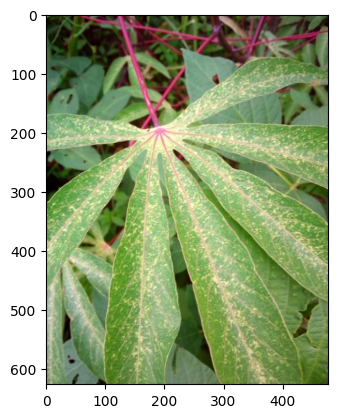

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
('/kaggle/input/pruebas-yuca', 'cgm.jpg')
cbsd
[2]


In [ ]:
ruta = "/kaggle/input/pruebas-yuca/cgm.jpg"
image = cv2.imread(ruta)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()
prediccion = categorizar(ruta)
prediccion1 = int(prediccion)
print(os.path.split(ruta))
print(classes[prediccion1])
print(prediccion)

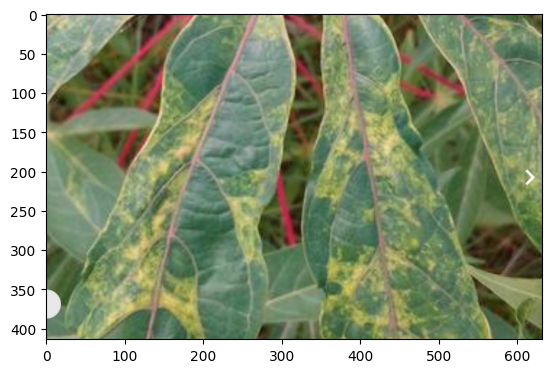

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
('/kaggle/input/pruebas-yuca', 'cmd.jpg')
healthy
[3]


In [ ]:
ruta = "/kaggle/input/pruebas-yuca/cmd.jpg"
image = cv2.imread(ruta)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()
prediccion = categorizar(ruta)
prediccion1 = int(prediccion)
print(os.path.split(ruta))
print(classes[prediccion1])
print(prediccion)

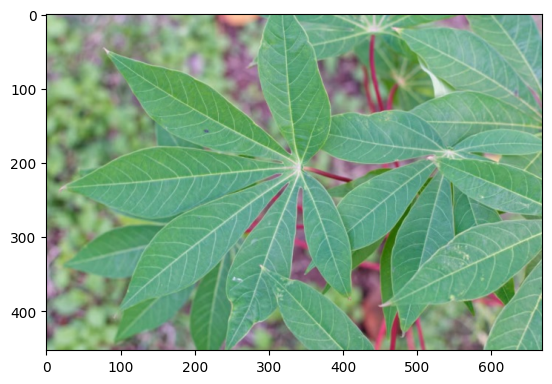

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
('/kaggle/input/pruebas-yuca', 'sana.jpg')
healthy
[3]


In [ ]:
ruta = "/kaggle/input/pruebas-yuca/sana.jpg"
image = cv2.imread(ruta)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()
prediccion = categorizar(ruta)
prediccion1 = int(prediccion)
print(os.path.split(ruta))
print(classes[prediccion1])
print(prediccion)

In [ ]:
# --- Entrenamiento de los modelos ---
def train_model(model, train_data, val_data, epochs=20):
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        class_weight={
        'cmd': 1.0,
        'cbb': 4.0,  # Aumentar peso
        'cbsd': 2.0,
        'healthy': 5.0,  # Máximo peso
        'cgm': 3.0
    }
    )
    return history


In [ ]:
# Crear y entrenar modelos

input_shape = (IMG_SIZE,IMG_SIZE,3)  # RGB channels
num_classes = len(class_labels)

# Modelo 1
cnn_model = create_basic_cnn(input_shape, num_classes)
history_cnn = train_model(cnn_model, train_data, val_data)

Epoch 1/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 92s 590ms/step - accuracy: 0.4111 - loss: 2.2941 - val_accuracy: 0.5695 - val_loss: 1.2028
Epoch 2/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 81s 544ms/step - accuracy: 0.5560 - loss: 1.2024 - val_accuracy: 0.5979 - val_loss: 1.1376
Epoch 3/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 79s 539ms/step - accuracy: 0.5668 - loss: 1.1789 - val_accuracy: 0.5988 - val_loss: 1.1213
Epoch 4/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 80s 542ms/step - accuracy: 0.5930 - loss: 1.1145 - val_accuracy: 0.6147 - val_loss: 1.0575
Epoch 5/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 81s 552ms/step - accuracy: 0.5921 - loss: 1.1019 - val_accuracy: 0.6005 - val_loss: 1.0601
Epoch 6/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 84s 568ms/step - accuracy: 0.5791 - loss: 1.1306 - val_accuracy: 0.6023 - val_loss: 1.0527
Epoch 7/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 83s 563ms/step - accuracy: 0.6110 - loss: 1.0616 - val_accuracy: 0.6227 - val_loss: 1.0974
Epoch 8/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 81s 550ms/step - accuracy: 0.5997 - loss: 1

<Figure size 640x480 with 0 Axes>

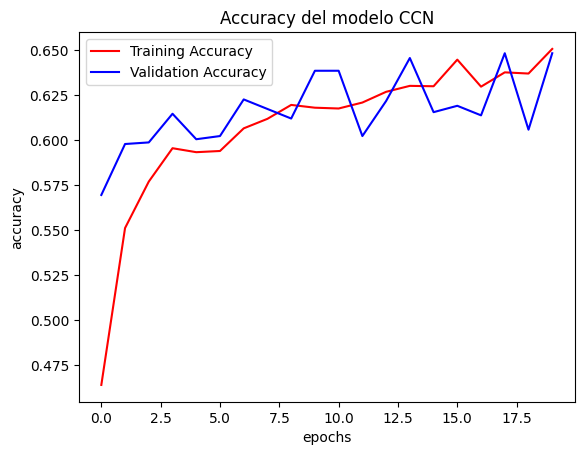

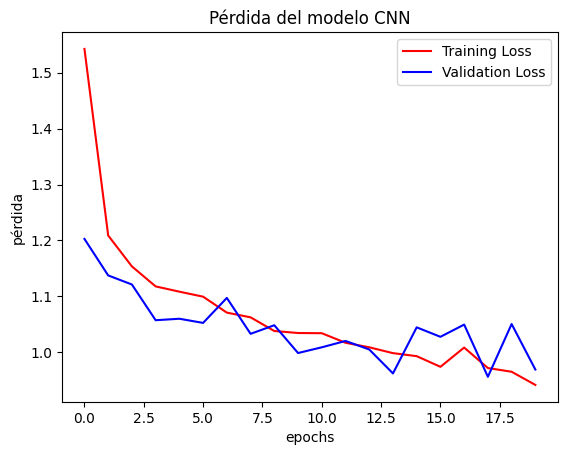

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Accuracy del modelo CNN')
plt.legend()
plt.figure()


plt.plot(epochs, loss, 'r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.xlabel('epochs')
plt.ylabel('pérdida')
plt.title('Pérdida del modelo CNN')
plt.legend()
plt.figure()

In [ ]:
from sklearn.metrics import classification_report

# Predicciones y evaluación
y_pred = cnn_model.predict(val_data)
y_pred_classes = y_pred.argmax(axis=1)
y_true = val_data.classes

# Reporte por clase
print(classification_report(y_true, y_pred_classes, target_names=classes))

36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 453ms/step
              precision    recall  f1-score   support

         cmd       0.12      0.04      0.06        93
         cbb       0.24      0.36      0.29       288
        cbsd       0.07      0.01      0.02       154
     healthy       0.49      0.52      0.50       531
         cgm       0.02      0.02      0.02        63

    accuracy                           0.35      1129
   macro avg       0.19      0.19      0.18      1129
weighted avg       0.31      0.35      0.32      1129



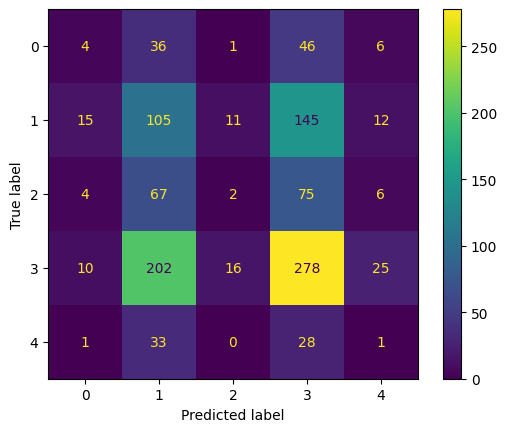

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predicciones y evaluación
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
# Modelo 2
cnn_dropout_model = create_cnn_with_dropout(input_shape, num_classes)
history_cnn_dropout = train_model(cnn_dropout_model, train_data, val_data )

Epoch 1/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 97s 619ms/step - accuracy: 0.4266 - loss: 2.2521 - val_accuracy: 0.4703 - val_loss: 1.3200
Epoch 2/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 83s 563ms/step - accuracy: 0.4755 - loss: 1.3654 - val_accuracy: 0.4703 - val_loss: 1.3263
Epoch 3/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 82s 556ms/step - accuracy: 0.4857 - loss: 1.3200 - val_accuracy: 0.5217 - val_loss: 1.2548
Epoch 4/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 82s 558ms/step - accuracy: 0.5215 - loss: 1.2794 - val_accuracy: 0.5589 - val_loss: 1.2391
Epoch 5/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 83s 561ms/step - accuracy: 0.5400 - loss: 1.2450 - val_accuracy: 0.5872 - val_loss: 1.1324
Epoch 6/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 82s 559ms/step - accuracy: 0.5668 - loss: 1.2062 - val_accuracy: 0.6014 - val_loss: 1.1072
Epoch 7/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 84s 569ms/step - accuracy: 0.5785 - loss: 1.1832 - val_accuracy: 0.5846 - val_loss: 1.1235
Epoch 8/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 85s 574ms/step - accuracy: 0.6033 - loss: 1

<Figure size 640x480 with 0 Axes>

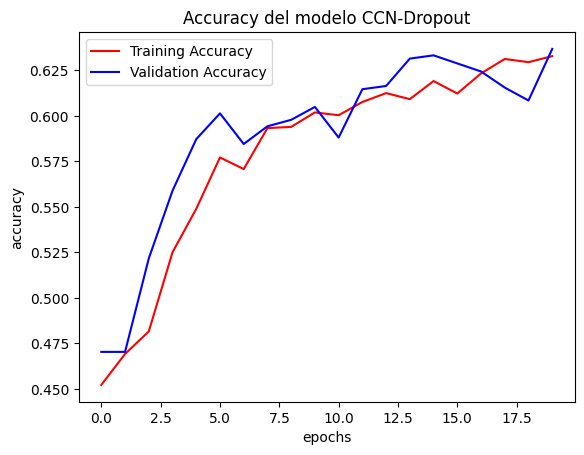

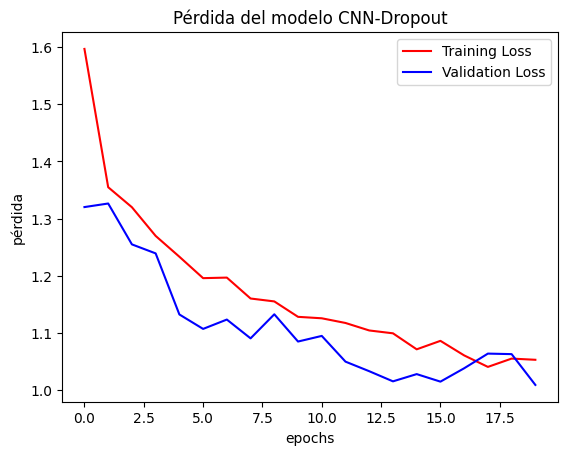

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history_cnn_dropout.history['accuracy']
val_acc = history_cnn_dropout.history['val_accuracy']
loss = history_cnn_dropout.history['loss']
val_loss = history_cnn_dropout.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Accuracy del modelo CNN-Dropout')
plt.legend()
plt.figure()


plt.plot(epochs, loss, 'r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.xlabel('epochs')
plt.ylabel('pérdida')
plt.title('Pérdida del modelo CNN-Dropout')
plt.legend()
plt.figure()

In [ ]:
from sklearn.metrics import classification_report

# Predicciones y evaluación
y_pred = cnn_dropout_model.predict(val_data)
y_pred_classes = y_pred.argmax(axis=1)
y_true = val_data.classes

# Reporte por clase
print(classification_report(y_true, y_pred_classes, target_names=classes))

36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 451ms/step
              precision    recall  f1-score   support

         cmd       0.14      0.01      0.02        93
         cbb       0.25      0.38      0.30       288
        cbsd       0.00      0.00      0.00       154
     healthy       0.46      0.59      0.52       531
         cgm       0.00      0.00      0.00        63

    accuracy                           0.37      1129
   macro avg       0.17      0.20      0.17      1129
weighted avg       0.29      0.37      0.32      1129



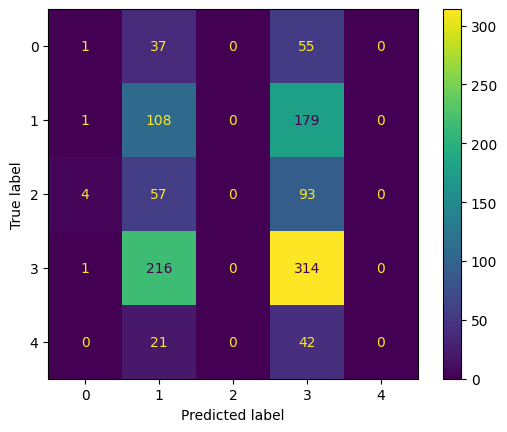

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predicciones y evaluación
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
# Modelo 3
# efficientnet_model = create_efficientnet(input_shape, num_classes)
# history_efficientnet = train_model(efficientnet_model, train_data, val_data, class_weights)

In [ ]:
# import matplotlib.pyplot as plt
# acc = history_efficientnet.history['accuracy']
# val_acc = history_efficientnet.history['val_accuracy']
# loss = history_efficientnet.history['loss']
# val_loss = history_efficientnet.history['val_loss']

# epochs = range(len(acc))

# plt.plot(epochs, acc, 'r', label='Training Accuracy')
# plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
# plt.xlabel('epochs')
# plt.ylabel('accuracy')
# plt.title('Accuracy del modelo CCN-Dropout')
# plt.legend()
# plt.figure()


# plt.plot(epochs, loss, 'r', label = 'Training Loss')
# plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
# plt.xlabel('epochs')
# plt.ylabel('pérdida')
# plt.title('Pérdida del modelo CNN-Dropout')
# plt.legend()
# plt.figure()

In [ ]:
# from sklearn.metrics import classification_report

# # Predicciones y evaluación
# y_pred = efficientnet_model.predict(val_data)
# y_pred_classes = y_pred.argmax(axis=1)
# y_true = val_data.classes

# # Reporte por clase
# print(classification_report(y_true, y_pred_classes, target_names=classes))

In [ ]:
# --- Guardar los modelos ---
cnn_model.save("cnn_model.h5")
cnn_dropout_model.save("cnn_dropout_model.h5")
efficientnet_model.save("efficientnet_model.h5")